In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain import hub

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
# retriever = db.as_retriever()
retriever = db.as_retriever(search_kwargs={"k": 2})

In [3]:
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o-mini")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm

c:\Users\Asus\Documents\LangGraph Course\VE_lang\Lib\site-packages\langsmith\client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document


class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str # This is basically boolean but for some reason its better to store as a str

In [6]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is releated to the restaurant Bella Vista"""

    score: str = Field(
        description="Question is about restaurant? If yes -> 'Yes' if not -> 'No'"
    )


def question_classifier(state: AgentState):
    question = state["messages"][-1].content # Get the last entry in the state

    system = """You are a classifier that determines whether a user's question is about one of the following topics:

    1. Information about the owner of Bella Vista, which is Antonio Rossi.
    2. Prices of dishes at Bella Vista (restaurant).
    3. Opening hours of Bella Vista (restaurant).

    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'. Remember, ONLY YES or NO, nothing else in the reponse!
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system), # This is system messages
            ("human", "User question: {question}"), # This is human message or human template basically
        ]
    )

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print("RESULT", result)
    state["on_topic"] = result.score # We store that in "on_topic" and we overwrite the state
    return state

In [7]:
# If yes then we want to return the string on_topic and if no then return off_topic
def on_topic_router(state):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"


def retrieve(state):
    question = state["messages"][-1].content # Extract the question from the user
    documents = retriever.invoke(question) # Get most relevant documents
    state["documents"] = documents # Store inside the "documents" key
    return state


def generate_answer(state):
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["messages"].append(generation) # Append answer of llm to the messages key which happens if we are on topic
    return state

# No need for LLM, we just return an AI message here and its cheaper + faster
def off_topic_response(state: AgentState):
    state["messages"].append(AIMessage(content="I cant respond to that!")) 
    return state

In [8]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier) #0
workflow.add_node("off_topic_response", off_topic_response) #2
workflow.add_node("retrieve", retrieve) #1
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve", #1
        "off_topic": "off_topic_response", #2
    },
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")
graph = workflow.compile()

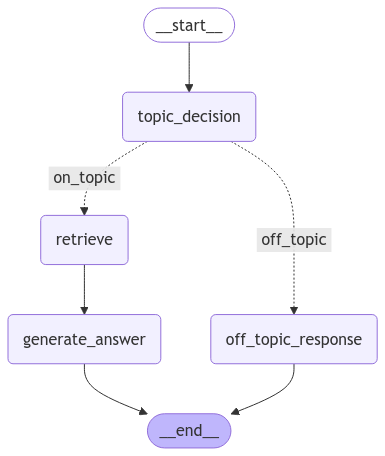

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:
graph.invoke(
    input={
        "messages": [HumanMessage(content="When does the bella vista restaurant open?")]
    }
)

RESULT score='Yes'


{'messages': [HumanMessage(content='When does the bella vista restaurant open?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Bella Vista opens from Monday to Sunday. On weekdays, it operates from 11:00 AM to 10:00 PM, and on weekends, it is open from 11:00 AM to 11:00 PM.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 198, 'total_tokens': 245, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-9bcd4bd2-36d8-4dcf-b3fb-2fbcb833258a-0', usage_metadata={'input_tokens': 198, 'output_tokens': 47, 'total_tokens': 245, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}

In [11]:
graph.invoke(
    input={"messages": [HumanMessage(content="What is articial intelligence?")]}
)

RESULT score='No'


{'messages': [HumanMessage(content='What is articial intelligence?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I cant respond to that!', additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}

### Retrieval with Tools

In [12]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

# This is basically for on topic
retriever_tool = create_retriever_tool(
    retriever, # Retriever
    "retriever_tool", # Name of retriever tool
    "Information related to Pricing, Opening hours of the owner of the restaurant Bella Vista", # tool description
)


@tool
def off_topic():
    """Catch all Questions NOT related to Pricing, Opening hours of the owner of the restaurant Bella Vista"""
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [13]:
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI


def agent(state):
    messages = state["messages"]
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]} # Using reducer function which is responsible for adding the response to the "messages" list


def should_continue(state) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1] # Get last msg
    if last_message.tool_calls: # If last msg has tool call attribute then return tools to make use of tool calling 
        return "tools"
    return END

In [15]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [18]:
workflow = StateGraph(AgentState)

workflow.add_edge(START, "agent")
workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

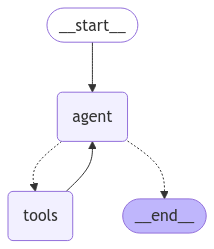

In [19]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [20]:
graph.invoke(
    input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]}
)

{'messages': [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='6c2e196d-39da-4baf-9850-ba75e4232046'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LCURAh8KJtZABQwxpIEM1f3S', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 102, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-770998ce-96b4-4b5b-be51-8053ee46380b-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': 'call_LCURAh8KJtZABQwxpIEM1f3S', 'type': 'tool_call'}], usage_metadata={'input_tokens': 102, 'output_tokens': 11, 'total_to

In [21]:
graph.invoke(
    input={
        "messages": [HumanMessage(content="When does the bella vista restaurant open?")]
    }
)

{'messages': [HumanMessage(content='When does the bella vista restaurant open?', additional_kwargs={}, response_metadata={}, id='6222e5cb-c45a-4f79-845b-1d728070732c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iFcnAib47tklUP6r5hC8y0C9', 'function': {'arguments': '{"query":"opening hours of Bella Vista"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 101, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-aa093b53-6c3d-4310-bfe4-463c58bd2a23-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'opening hours of Bella Vista'}, 'id': 'call_iFcnAib47tklUP6r5hC8y0

In [ ]:
# When to use tool calling or directly access retriever?
## If ur agent is simple and only needs an answer then tool calling approach is fine and works very well
## If u need to return documents then it wont work as they are not stored in agent state and would need to use retriever